Notebook para la detección automática de módulos, incluyendo la anotación en formato `Supervisley`.  

Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.

In [36]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import requests
import copy

from unet_model import construct_unet

from PIL import Image
from imutils.paths import list_images

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [37]:
# Carpeta de imágenes D:\Documentos\PV_Vision\pv-vision\examples\transform_seg\field_pipeline\raw_img_gray

#images = [cv.imread(file) for file in list_images('D:/Documentos/PV_Vision/pv-vision/examples/transform_seg/field_pipeline/raw_img_gray')]
images = [cv.imread(file) for file in list_images(
    'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/Modulos')]
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes: {len(images)}')

Número de imágenes: 24


El siguiente código define una clase `myDataset` que hereda de la clase `Dataset` de PyTorch. Esta clase se utiliza para cargar y transformar las imágenes que se pasarán al modelo. La transformación se aplica a cada imagen cuando se accede a ella, no todas a la vez al principio. Esto es más eficiente en términos de memoria, especialmente cuando se trabaja con conjuntos de datos grandes.

In [38]:
# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

El siguiente código define una transformación que se aplica a las imágenes antes de pasarlas al modelo. La transformación consta de dos pasos: convertir la imagen a un tensor de PyTorch y normalizar los valores de los píxeles. Luego, se crea una instancia de la clase `myDataset` que se utiliza para cargar y transformar las imágenes.

In [39]:
# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Crear una instancia de la clase myDataset. Esta clase es un tipo personalizado de Dataset que se utiliza para cargar y transformar las imágenes.
# La lista de imágenes y la transformación compuesta se pasan como argumentos al inicializar el conjunto de datos.
imgset = myDataset(images, transform)

In [40]:
# Carpeta de pesos del modelo

#weight_path = 'D:\Documentos\PV_Vision\Neural_Network_W\module_segmentation\unet_grayscale'
weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/module_segmentation/unet_grayscale/model.pt'

In [41]:
# Definir el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se utilizará. De lo contrario, se utilizará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')

# Crear una instancia del modelo U-Net con 2 canales de salida. 
# El número de canales de salida generalmente corresponde al número de clases que el modelo está diseñado para predecir.
unet = construct_unet(2)

# Envolver el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

Dispositivo: cuda:0


In [42]:
# Inicializar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar. En este caso, es la instancia de U-Net que se ha creado anteriormente.
    model=unet,
    # El conjunto de datos que se utilizará para las pruebas. En este caso, es el conjunto de imágenes que se ha cargado y transformado anteriormente.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo. En este caso, es el dispositivo que hemos definido anteriormente (GPU si está disponible, de lo contrario CPU).
    device=device,
    # El directorio donde se guardarán los resultados. En este caso, los resultados se guardarán en un directorio llamado 
    # 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/output'.
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_modulo_prediction'
)

# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)

In [43]:
# Ejecutar el modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)

100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


In [44]:
# Se definió una transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])
#resize = transforms.Compose([transforms.PILToTensor()])
# Se definió un mapa de colores para las diferentes clases de máscaras.
color_map = {
    'module': (68, 114, 148),
    'bg': (222, 156, 83)
}

# Se definió una función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        module = masks==1
        bg = masks==2
        masks_each.append(torch.dstack([module, bg]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['module', 'bg']])
    return F.to_pil_image(combo)

In [45]:
# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)

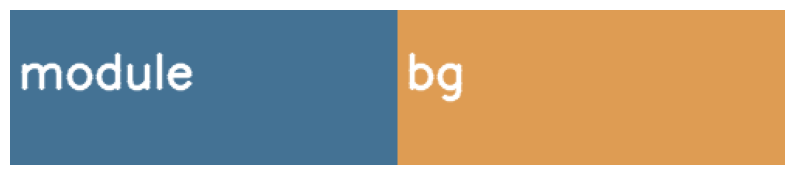

In [11]:
# Mostrar el mapa de colores junto con las clases correspondientes. Cuadros de colores con los nombres de las clases.

# Definir el tamaño de la imagen
height = 100
width = 500

# Crear una imagen en blanco con el tamaño especificado
color_map_img = np.zeros((height, width, 3), dtype=np.uint8)

# Definir el mapa de colores y los nombres de las clases
#color_map = {'dark': (68, 114, 148), 'cross': (77, 137, 99), 'crack': (165, 59, 63), 'busbar': (222, 156, 83)}
class_names = list(color_map.keys())

# Calcular el ancho de cada cuadro de color
color_box_width = width // len(class_names)

# Dibujar los cuadros de color y los nombres de las clases en la imagen
for i, class_name in enumerate(class_names):
    color = color_map[class_name]
    start_x = i * color_box_width
    end_x = (i + 1) * color_box_width
    color_map_img[:, start_x:end_x] = color
    text_x = start_x + 5
    text_y = height // 2
    cv.putText(color_map_img, class_name, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)

# Mostrar la imagen
plt.figure(figsize=(10, 5))
plt.imshow(color_map_img)
plt.axis('off')
plt.show()

# cv.imshow('Color Map', color_map_img)
# cv.waitKey(0)
# cv.destroyAllWindows()


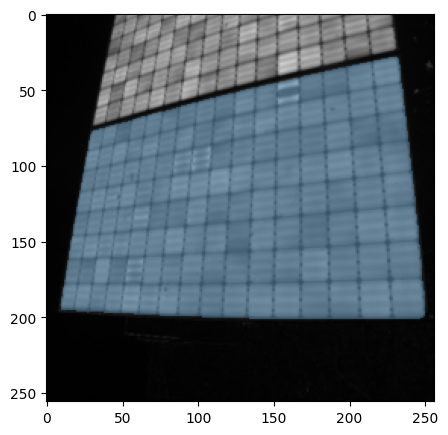

In [76]:
# Se dibujan las máscaras sobre las imágenes originales.
plt.figure(figsize=(5, 6))
plt.imshow(draw_mask(images[15], masks_each[15]))
# Imprime los valores de la máscara
#print(masks_each[13])

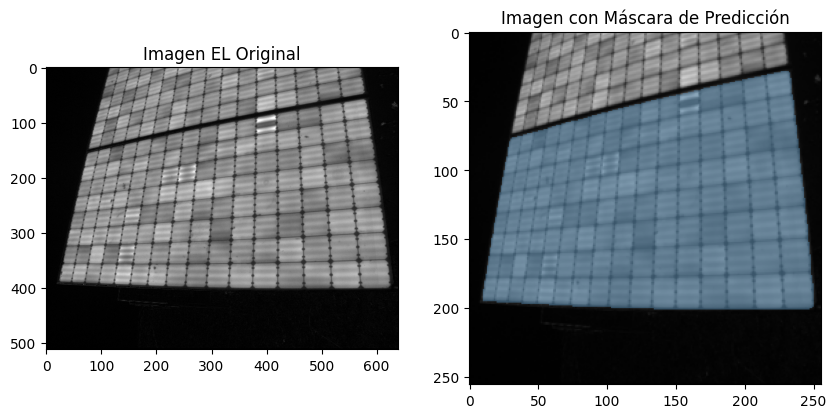

In [63]:
import matplotlib.pyplot as plt

# Se visualizan las imágenes y las máscaras correspondientes.
num_img = 15
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(images[num_img])
plt.title('Imagen EL Original')

plt.subplot(1, 2, 2)
plt.imshow(np.array(draw_mask(images[num_img], masks_each[num_img])))
plt.title('Imagen con Máscara de Predicción')

plt.show()


Celdas para el almacenamiento de las máscaras del módulo en formato `Supervisely` (`.json`)

In [48]:
import os
import json
import base64
import zlib
from io import BytesIO

In [49]:
# Función para convertir una imagen binaria en una cadena base64 comprimida
def mask_2_base64(mask):
    """Convierte una máscara binaria en una cadena base64 comprimida.
    Args:
        mask (np.array): Máscara binaria.
    Returns:
        str: Cadena base64 comprimida."""
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0, 0, 0, 255, 255, 255])
    bytes_io = BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

# Función para convertir una cadena base64 comprimida en una imagen binaria
def base64_2_mask(s):
    """Convierte una cadena base64 comprimida en una máscara binaria.
    Args:
        s (str): Cadena base64 comprimida.
    Returns:
        np.array: Máscara binaria."""
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)  # Cambiado de fromstring a frombuffer
    mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

# Función para encontrar la esquina superior izquierda del área coloreada en la máscara
def find_mask_origin(mask):
    coords = np.argwhere(mask)
    if coords.size == 0:
        return [0, 0]
    top_left = coords.min(axis=0)
    top_right = coords.max(axis=0)
    return top_left[::-1].tolist()
    # retornar las coordenadas del centro de la máscara
    #return [int(mask.shape[1]/2), int(mask.shape[0]/2)]

# Función para recortar la máscara a un rectángulo que contiene la región coloreada
def crop_mask(mask):
    coords = np.argwhere(mask)
    if coords.size == 0:
        return mask
    top_left = coords.min(axis=0)
    bottom_right = coords.max(axis=0)
    return mask[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]

# Función para crear anotaciones en formato Supervisely
def create_supervisely_annotation(mask, image_path):
    mask_origin = find_mask_origin(mask)
    #mask_origin = [128, 128]
    cropped_mask = crop_mask(mask)
    #encoded_mask = mask_2_base64(mask)
    encoded_mask = mask_2_base64(cropped_mask)
    
    annotation = {
        "description": "",
        "name": os.path.splitext(os.path.basename(image_path))[0],
        "tags": [],
        "size": {
            "height": mask.shape[0],
            "width": mask.shape[1]
        },
        "objects": [
            {
                "description": "",
                "geometryType": "bitmap",
                "tags": [],
                "classTitle": "module_unet",
                "bitmap": {
                    "data": encoded_mask,
                    "origin": mask_origin
                    
                }
            }
        ]
    }
    return annotation

In [50]:
# Función para guardar la anotación en un archivo JSON
def save_annotation(annotation, output_path):
    with open(output_path, 'w') as outfile:
        json.dump(annotation, outfile, indent=4)

# Función para convertir máscaras a anotaciones Supervisely y guardarlas
def convert_masks_to_supervisely(masks_each, image_paths, output_dir):
    """
    Genera una máscara de predicciones en formato .json

    Args:
        masks_each (list): Lista de máscaras predichas para cada imagen.
        image_paths (list): Lista de paths de las imágenes correspondientes con las máscaras.
        output_dir (str): Directorio de salida donde se guarda el archivo .json
    Returns:
        

    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for mask, image_path in zip(masks_each, image_paths):
        module_mask = mask[0].cpu().numpy()

        # Convertir la máscara a uint8 para redimensionar
        module_mask_uint8 = module_mask.astype(np.uint8) * 255

        # Redimensionar la máscara a 640x512
        resized_mask_uint8 = cv.resize(module_mask_uint8, (640, 512), interpolation=cv.INTER_NEAREST)

        # Convertir la máscara redimensionada de vuelta a booleano
        resized_mask = resized_mask_uint8.astype(bool)

        # Verificar la conversión base64
        #test_base64_conversion(resized_mask)
        if np.array_equal(module_mask, resized_mask):
            print("Base64 conversion successful!")


        annotation = create_supervisely_annotation(resized_mask, image_path)
        output_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + '.json')

        save_annotation(annotation, output_path)
        #print(f"Annotation saved: {output_path}")


# Función de prueba de la conversión base64
def test_base64_conversion(mask):
    # Convertir la máscara a base64
    encoded_mask = mask_2_base64(mask)
    # Convertir base64 de vuelta a máscara
    decoded_mask = base64_2_mask(encoded_mask)
    # Verificar si la máscara original y la decodificada son iguales
    if np.array_equal(mask, decoded_mask):
        print("Base64 conversion successful!")
    else:
        print("Base64 conversion failed!")

In [51]:
# Directorios de entrada y salida
image_dir = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Datasets_EL/Modulos'
output_dir = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/output_json'

# Lista de rutas de las imágenes de entrada
image_paths = list(list_images(image_dir))
print(f'Número de imágenes: {len(image_paths)}')

Número de imágenes: 24


In [52]:
# Convertir máscaras a anotaciones Supervisely y guardarlas
convert_masks_to_supervisely(masks_each, image_paths, output_dir)

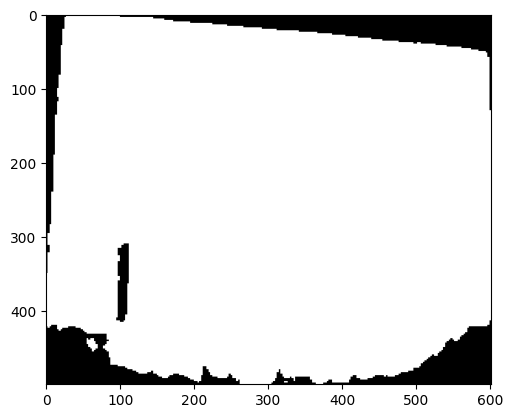

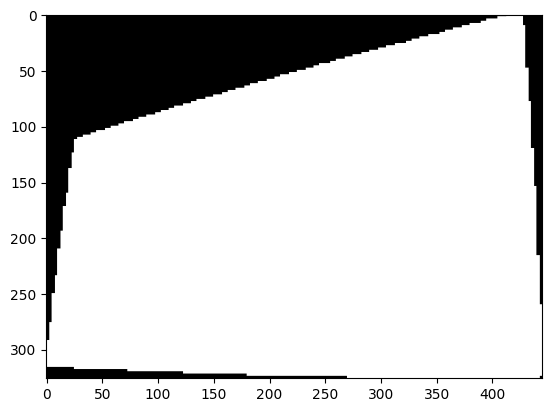

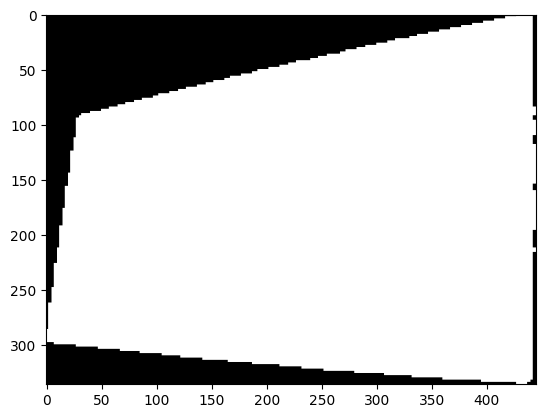

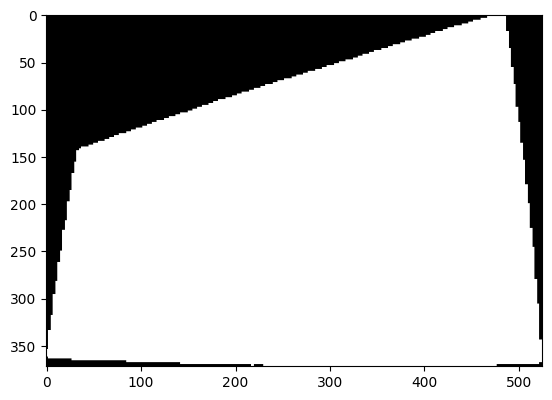

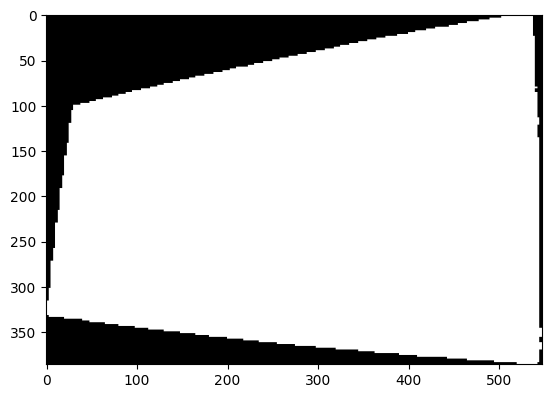

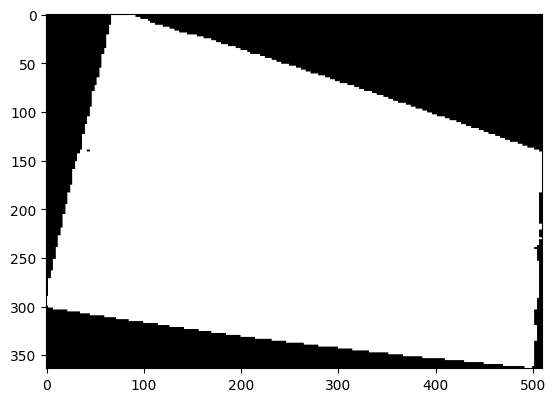

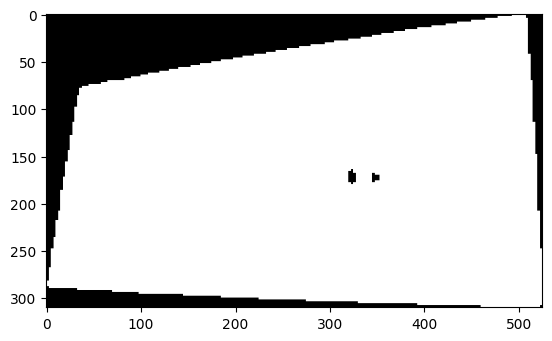

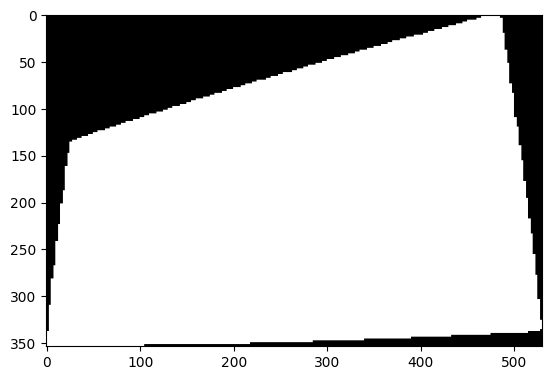

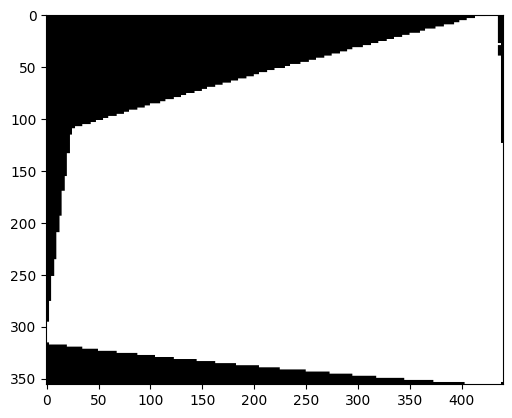

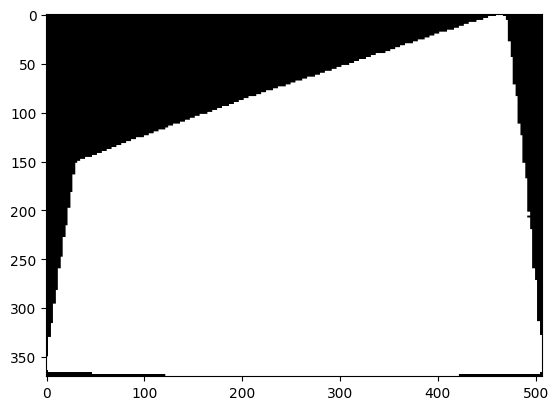

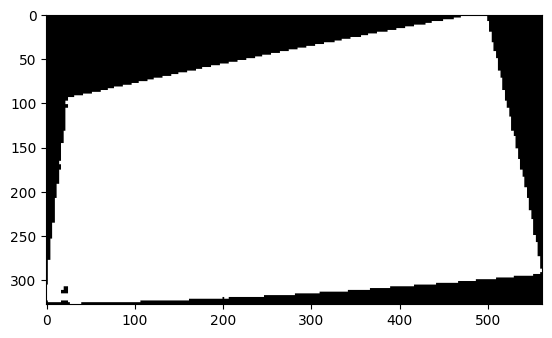

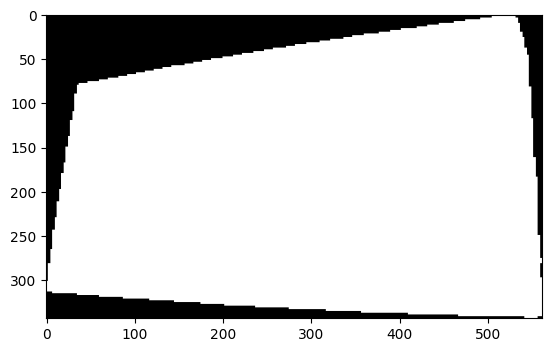

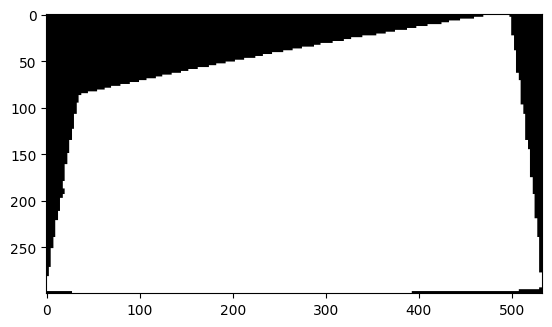

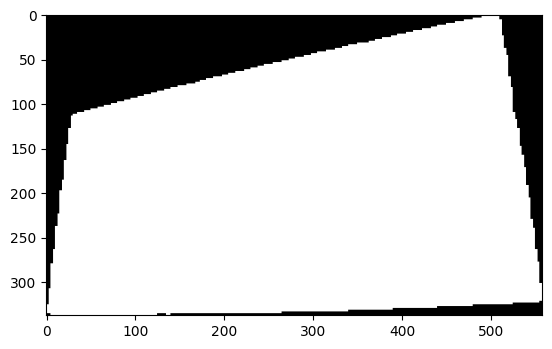

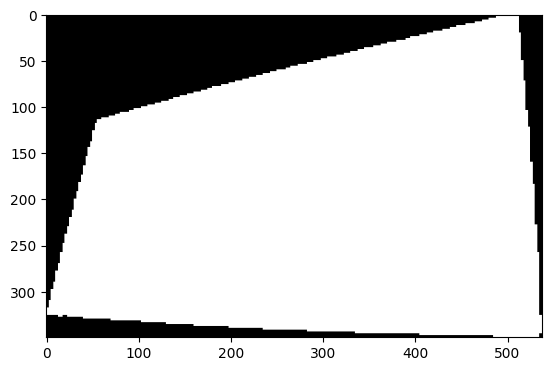

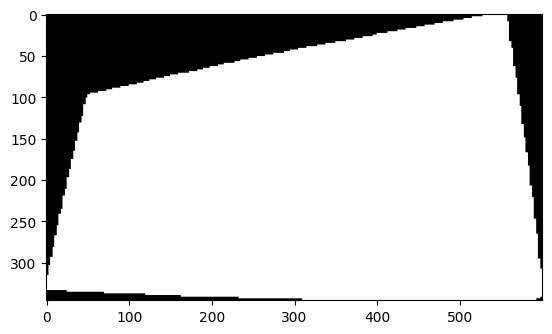

In [52]:
# Lectura de las anotaciones Supervisely y visualización de las máscaras

# Las anotaciones Supervisely se almacenan en archivos JSON en el directorio `output_dir`
# con `mask_2_base64(mask)` se convierte la máscara binaria en una cadena base64 comprimida
# con `base64_2_mask(s)` se convierte la cadena base64 comprimida en una máscara binaria

# Listar todos los archivos JSON en el directorio
json_files = [f for f in os.listdir(output_dir) if f.endswith('.json')]

for json_file in json_files:
    with open(os.path.join(output_dir, json_file), 'r') as f:
        data = json.load(f)
        # Asumiendo que la estructura del JSON incluye un campo con la cadena base64
        # Esto puede necesitar ajustes dependiendo de la estructura exacta del JSON
        base64_str = data['objects'][0]['bitmap']['data']
        mask = base64_2_mask(base64_str)
        plt.imshow(mask, cmap='gray')
        plt.show()

